## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.st/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.st/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.st/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.st/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [1]:
import numpy as np
from scipy.optimize import fsolve
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import ldfparser
from scipy.integrate import solve_ivp

In [2]:
#######################
## Physical Constant ##
#######################
e = 1.6e-19 # electron charge [C]
epsilon_0 = 8.854e-12 # permittivity of vacuum [F/m]
kB = 1.38e-23 #Bolzmann const [kg m2/s2/K]
mp = 146*1.67e-27 # mass of positive ion [kg] SF6
Tm = 0.1 # Negative ion temperature [eV]
hr = 0.6 # h-factor
rp = 0.1e-3 # probe radius [m]
lp = 5.5e-3 # probe length [m]

In [3]:
class Iterative_method():
    def __init__(self, ne, Te, V_sat, I_sat, V_p):
        self.ne = ne
        self.Te = Te
        self.V_sat = V_sat
        self.I_sat = I_sat
        self.gamma = self.Te/Tm
        self.V_p = V_p
        self.De = np.sqrt(epsilon_0*kB*Te/(e**2*ne)) #electron debye length
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(ne,Te,V_sat,I_sat))
        
    def alpha_convert(self,a_0):
        def eqn21(a_s):
            return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+self.gamma*a_s)*(1-self.gamma))
        ans_arr = np.round(fsolve(eqn21,np.logspace(-2,2,5)),4)
        ans_arr = np.unique(ans_arr)
        a_s = min(ans_arr)
        print("a_0: {:.4f}\t a_s: {}\t gamma: {:.4f}\t sol_number: {}".format(a_0, a_s, self.gamma, len(ans_arr)))
        return a_s
    
    def modified_Bohm(self,a_s):
        uB = np.sqrt(e*self.Te/mp)*np.sqrt((1+a_s)/(1+self.gamma*a_s))
        return uB
    
    def r_sh_calculation(self, J): 
            r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/mp)*(self.V_sat - self.V_p)**1.5/J)
            #r_sh = rp
            return r_sh
            
    def iteration(self):
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(self.ne,self.Te,self.V_sat,self.I_sat))
        count = 0
        a_0 = 3
        r_sh_0 = rp
        pi = 3.141592653589793
        S_eff = 2*(pi)*r_sh_0*lp
        
        while True:
            MAX_COUNT = 100
            count += 1
            a_s = self.alpha_convert(a_0)
            uB = self.modified_Bohm(a_s) # uB_k
            np = self.I_sat/(hr*S_eff*e*uB) # np_k , S_k-1
            comp = a_0 # for loop condition
            a_0 = np/self.ne-1 # a_0_k
            J = hr*e*np*uB # J_k
            r_sh = self.r_sh_calculation(J) #r_sh_k
            S_eff = 2*pi*r_sh*lp
            
            #print(count, a_0)
            
            if abs(comp - a_0) < 0.001*a_0:
                return a_0
                break
            if count == MAX_COUNT:
                print('-----------No Convergence!---------------------')
                break
        print('--------------------------------------------------')

In [6]:
workDir = './211216(SF6)/bias (float) 56mm B-field/'
parser = ldfparser.LDF(workDir)

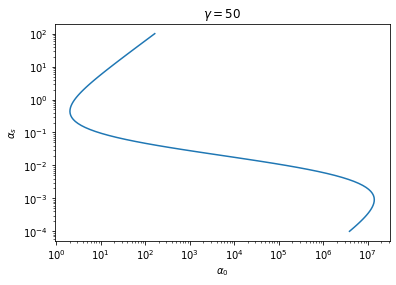

In [7]:
gamma = 50
a_s = np.logspace(-4,2,100)
plt.plot(a_s*np.exp(-1/2*(1+a_s)/(1+gamma*a_s)*(1-gamma)),a_s)
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$\alpha_s$')
plt.title(r'$\gamma={}$'.format(gamma))
plt.yscale('log')
plt.xscale('log')

In [8]:
distances, nes, nms, alphas, Vps, Tes, Nis = [], [], [], [], [], [], []

ldf_files = parser.ldf_paths()
for file in ldf_files:
    IV, eedf, result = parser.pull_attr(file, need_return=True)
    print(file)
    distance = float(file.split('/')[-1][:-4])
    ne = result['Ne'][0]
    Te = result['eepf_Te'][0]
    Ni = result['Ni'][0]
    #Isat = result['Isat'][0]
    #Vsat = result['Vsat'][0]
    
    Isat = -np.array(IV['I'])[0]
    Vsat = -np.array(IV['V'])[0]
    #Isat = -np.array(IV[IV['V']<-20]['I'])[-1]
    #Vsat = -np.array(IV[IV['V']<-20]['V'])[-1]
    
    Vp = result['Vp'][0]
    exp = Iterative_method(ne,Te,Vsat,Isat,Vp)
    alpha = exp.iteration()
    nm = ne*alpha
    print("Vp: {}, Vsat: {}, Isat: {}, Ni: {}\n\n".format(Vp, Vsat, Isat, Ni))
    
    Nis.append(Ni)
    Vps.append(Vp)
    alphas.append(alpha)
    nes.append(ne)
    nms.append(nm)
    distances.append(distance)
    Tes.append(Te)

./211216(SF6)/bias (float) 56mm B-field/100.ldf
a_0: 3.0000	 a_s: 0.1825	 gamma: 42.1908	 sol_number: 2
a_0: 46.3905	 a_s: 0.0518	 gamma: 42.1908	 sol_number: 2
a_0: 28.9926	 a_s: 0.06	 gamma: 42.1908	 sol_number: 2
a_0: 30.2425	 a_s: 0.0592	 gamma: 42.1908	 sol_number: 2
a_0: 29.9983	 a_s: 0.0594	 gamma: 42.1908	 sol_number: 2
Vp: 4.26674, Vsat: 41.8039, Isat: 0.000348615, Ni: 3.39684e+17


./211216(SF6)/bias (float) 56mm B-field/110.ldf
a_0: 3.0000	 a_s: 0.1772	 gamma: 39.1342	 sol_number: 2
a_0: 46.7898	 a_s: 0.0489	 gamma: 39.1342	 sol_number: 2
a_0: 29.6420	 a_s: 0.0567	 gamma: 39.1342	 sol_number: 2
a_0: 31.0683	 a_s: 0.0558	 gamma: 39.1342	 sol_number: 2
a_0: 30.8962	 a_s: 0.0559	 gamma: 39.1342	 sol_number: 2
Vp: 4.00878, Vsat: 41.7765, Isat: 0.000360706, Ni: 3.45081e+17


./211216(SF6)/bias (float) 56mm B-field/120.ldf
a_0: 3.0000	 a_s: 0.1747	 gamma: 37.8616	 sol_number: 2
a_0: 46.6841	 a_s: 0.0476	 gamma: 37.8616	 sol_number: 2
a_0: 29.7799	 a_s: 0.0553	 gamma: 37.8616	 sol_

C:\Users\GUNU\anaconda3\envs\tf24\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

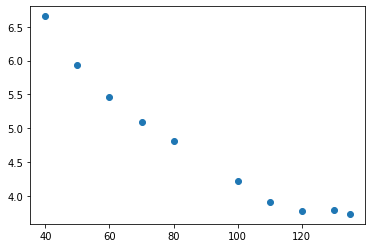

In [9]:
plt.scatter(distances, Tes)

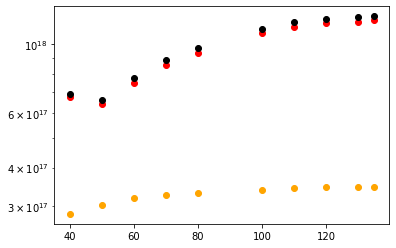

In [10]:
plt.scatter(distances, np.array(Nis), c='orange')
plt.scatter(distances, np.array(nms), c='red')
plt.scatter(distances, np.array(nes) + np.array(nms), c='black')

plt.yscale('log')

Text(0, 0.5, '$\\alpha_0$')

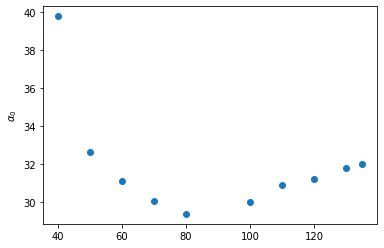

In [11]:
plt.scatter(distances, alphas)
plt.ylabel(r'$\alpha_0$')

In [12]:
alphas

[29.97974268446948,
 30.909357300721602,
 31.204215336994757,
 31.771682070212343,
 31.979443898662794,
 39.79510304567824,
 32.614036591318396,
 31.08829215657166,
 30.054661058746692,
 29.36669201440458]

Text(0, 0.5, 'Electron density $[m^{-3}]$')

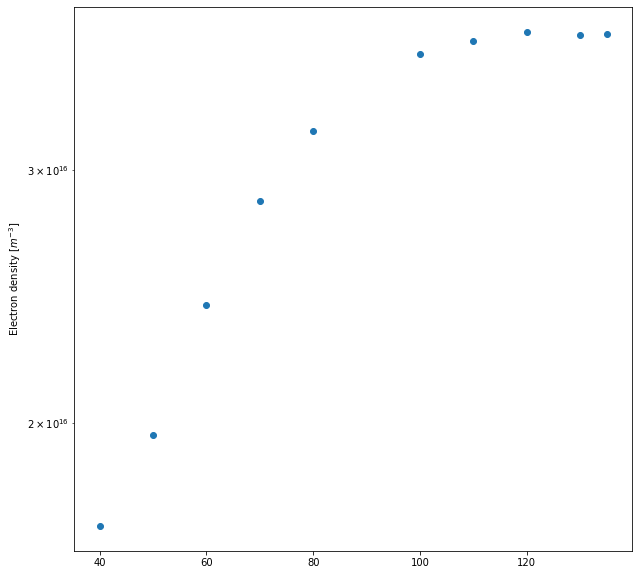

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(distances, nes)
plt.yscale('log')
plt.ylabel('Electron density $[m^{-3}]$')

(0.0, 15.0)

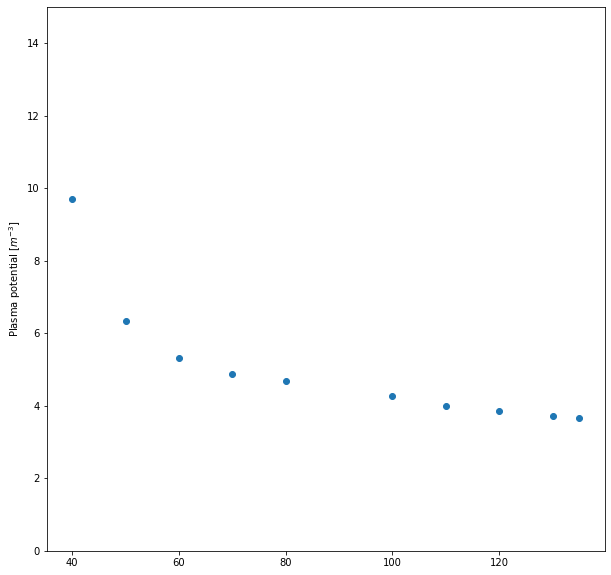

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(distances, Vps)
plt.ylabel('Plasma potential $[m^{-3}]$')
plt.ylim(0,15)

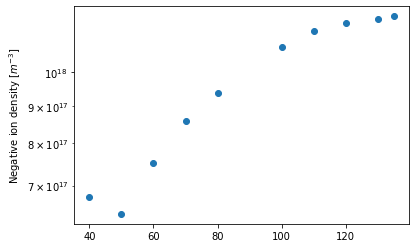

In [15]:
plt.ylabel('Negative ion density $[m^{-3}]$')
plt.scatter(distances, nms)
plt.yscale('log')

Text(0, 0.5, 'Negative ion density $[m^{-3}]$')

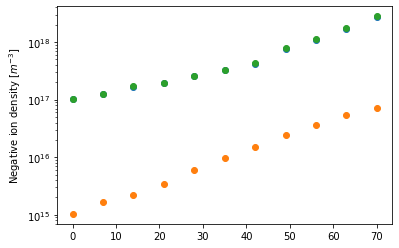

In [156]:
plt.scatter(distances, nms)
plt.scatter(distances, nes)
plt.scatter(distances, np.array(nes) + np.array(nms))
plt.yscale('log')
plt.ylabel('Negative ion density $[m^{-3}]$')

In [26]:
ne = result['Ne'][0]
Te = result['eepf_Te'][0]
Isat = result['Isat'][0]
Vsat = result['Vsat'][0]
Vp = result['Vp'][0]

In [42]:
ne = 1e14 # 1/m3
Te = 2 # eV
Isat = 0.000033
Vsat = 20.5937
Vp = 10

In [43]:
exp = Iterative_method(ne,Te,Vsat,Isat,Vp)
exp.iteration()

1 9.993144036088852
2 284.3567981085936
3 1426.5949749931574
4 3084.0299408756578
5 4530.528698625436
6 5490.731241753286
7 6044.568961118748
8 6342.08111325082
9 6496.2804703189695
10 6574.779524419255
11 6614.383824091366
--------------------------------------------------


In [ ]:
from scipy.integrate import solve_bvp
rp= 25e-6
J = 10
V = 50
uB = 100
R= 50e-5
def fun(r, y, r_sh):
    return np.vstack((r_sh*J/(r*epsilon_0*y[1])-y[0]/r, e*y[0]/(mp*y[1])))

def bc(ya,yb,p):
    return np.array([yb[0],ya[1]-np.sqrt(2*e*V/mp),yb[1]-uB])
# a=시작
# b=끝
# 0=E
# 1=u
n = 20
r = np.linspace(rp, 3*R, n)
y = np.array([np.linspace(V, 0, n)/(R-rp), np.linspace(np.sqrt(2*e*V/mp), uB, n)])

sol = solve_bvp(fun, bc, r, y,p=(10*rp,))

if sol.status != 0:
    print("WARNING: sol.status is %d" % sol.status)
print(sol.message)

plt.subplot(2, 1, 1)
plt.plot(sol.x, sol.y[0], color='#801010', label='$y_0(x)$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.subplot(2, 1, 2)
plt.plot(sol.x, sol.y[1], '-', color='C0', label='$y_1(x)$')
plt.xlabel('$x$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.show()